In [15]:
import numpy as np
import scipy.sparse as sp
import os
import sys
from vis import plot_superadj

In [16]:
from ogb.nodeproppred import DglNodePropPredDataset
def load_assortative(dataset="cora"):
    import pickle as pkl
    import networkx as nx
    import scipy.sparse as sp
    import torch

    def parse_index_file(filename):
        index = []
        for line in open(filename):
            index.append(int(line.strip()))
        return index

    def sample_mask(idx, l):
        """Create mask."""
        mask = np.zeros(l)
        mask[idx] = 1
        return np.array(mask, dtype=np.bool)

    if dataset in ["cora", "citeseer", "pubmed"]:
        names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
        objects = []

        for i in range(len(names)):
            '''
            fix Pickle incompatibility of numpy arrays between Python 2 and 3
            https://stackoverflow.com/questions/11305790/pickle-incompatibility-of-numpy-arrays-between-python-2-and-3
            '''
            with open("/data/liuyue/New/SBM/mySBM/data/{}/ind.{}.{}".format(dataset, dataset, names[i]), 'rb') as rf:
                u = pkl._Unpickler(rf)
                u.encoding = 'latin1'
                cur_data = u.load()
                objects.append(cur_data)
            # objects.append(
            #     pkl.load(open("data/ind.{}.{}".format(dataset, names[i]), 'rb')))
        x, y, tx, ty, allx, ally, graph = tuple(objects)
        test_idx_reorder = parse_index_file(
            "/data/liuyue/New/SBM/mySBM/data/{}/ind.{}.test.index".format(dataset, dataset))
        test_idx_range = np.sort(test_idx_reorder)


        if dataset == 'citeseer':
            # Fix citeseer dataset (there are some isolated nodes in the graph)
            # Find isolated nodes, add them as zero-vecs into the right position
            test_idx_range_full = range(
                min(test_idx_reorder), max(test_idx_reorder) + 1)
            tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
            tx_extended[test_idx_range - min(test_idx_range), :] = tx
            tx = tx_extended
            ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
            ty_extended[test_idx_range - min(test_idx_range), :] = ty
            ty = ty_extended

        features = sp.vstack((allx, tx)).tolil()
        features[test_idx_reorder, :] = features[test_idx_range, :]
        features = torch.FloatTensor(np.array(features.todense()))
        adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))
        
        labels = np.vstack((ally, ty))
        labels[test_idx_reorder, :] = labels[test_idx_range, :]
        
        idx_test = test_idx_range.tolist()
        idx_train = range(len(y))
        idx_val = range(len(y), len(y) + 500)

        train_mask = sample_mask(idx_train, labels.shape[0])
        val_mask = sample_mask(idx_val, labels.shape[0])
        test_mask = sample_mask(idx_test, labels.shape[0])

        y_train = np.zeros(labels.shape)
        y_val = np.zeros(labels.shape)
        y_test = np.zeros(labels.shape)
        y_train[train_mask, :] = labels[train_mask, :]
        y_val[val_mask, :] = labels[val_mask, :]
        y_test[test_mask, :] = labels[test_mask, :]

        adj = adj.toarray()
        labels = labels.argmax(1)
        # idx = labels.argsort(0)
        # adj = adj[idx, :][:, idx]
        # labels = labels[idx]
        # features = features[idx]

        adj = sp.coo_matrix(adj)
        features = sp.coo_matrix(features)

        return adj, features, labels
    elif dataset == "wiki":
        f = open('/data/liuyue/New/SBM/mySBM/data/wiki/graph.txt','r')
        adj, xind, yind = [], [], []
        for line in f.readlines():
            line = line.split()
            
            xind.append(int(line[0]))
            yind.append(int(line[1]))
            adj.append([int(line[0]), int(line[1])])
        f.close()
        ##print(len(adj))

        f = open('/data/liuyue/New/SBM/mySBM/data/wiki/group.txt','r')
        label = []
        for line in f.readlines():
            line = line.split()
            label.append(int(line[1]))
        f.close()

        f = open('/data/liuyue/New/SBM/mySBM/data/wiki/tfidf.txt','r')
        fea_idx = []
        fea = []
        adj = np.array(adj)
        adj = np.vstack((adj, adj[:,[1,0]]))
        adj = np.unique(adj, axis=0)
        
        labelset = np.unique(label)
        labeldict = dict(zip(labelset, range(len(labelset))))
        label = np.array([labeldict[x] for x in label])
        adj = sp.coo_matrix((np.ones(len(adj)), (adj[:,0], adj[:,1])), shape=(len(label), len(label)))

        for line in f.readlines():
            line = line.split()
            fea_idx.append([int(line[0]), int(line[1])])
            fea.append(float(line[2]))
        f.close()

        fea_idx = np.array(fea_idx)
        features = sp.coo_matrix((fea, (fea_idx[:,0], fea_idx[:,1])), shape=(len(label), 4973)).toarray()
        scaler = preprocessing.MinMaxScaler()
        #features = preprocess.normalize(features, norm='l2')
        features = scaler.fit_transform(features)
        # features = torch.FloatTensor(features)
        features = sp.coo_matrix(features)

        return adj, features, label
    elif dataset in ["ogbn-arxiv", "ogbn-products"]:
        dataset = DglNodePropPredDataset(name="{}".format(dataset))
        g, labels = dataset[0]
        edge_indices = g.adj_sparse(fmt="coo")
        n, m = labels.shape[0], edge_indices[0].shape[0]
        adj = sp.coo_matrix((np.ones(m), (edge_indices[0].numpy(), edge_indices[1].numpy())), shape=(n,n))
        features = g.ndata["feat"]
        features = sp.coo_matrix(features)

        if labels.ndim > 1:
            if labels.shape[1] == 1:
                labels = labels.view(-1)
            else:
                labels = labels.argmax(1)
        labels = labels.numpy()
        return adj, features, labels
    elif dataset in ["amazon-photo", "amazon-computers", "cora-full"]:
        map2names = {
            "amazon-photo": "/data/liuyue/New/SBM/mySBM/data/amazon_electronics_photo.npz",
            "amazon-computers": "/data/liuyue/New/SBM/mySBM/data/amazon_electronics_computers.npz",
            "cora-full": "/data/liuyue/New/SBM/mySBM/data/cora_full.npz",
        }

        data = np.load(map2names[dataset])
        # print(list(data.keys()))
        adj_data, adj_indices, adj_indptr, adj_shape = data["adj_data"], data["adj_indices"], data["adj_indptr"], data["adj_shape"]
        attr_data, attr_indices, attr_indptr, attr_shape = data["attr_data"], data["attr_indices"], data["attr_indptr"], data["attr_shape"]
        labels = data["labels"]

        adj = sp.csr_matrix((adj_data, adj_indices, adj_indptr), shape=adj_shape).tocoo()
        features = sp.csr_matrix((attr_data, attr_indices, attr_indptr), shape=attr_shape).tocoo()

        if labels.ndim > 1:
            if labels.shape[1] == 1:
                labels = labels.reshape(-1)
            else:
                labels = labels.argmax(1)

        return adj, features, labels
    else:
        raise NotImplementedError()

In [17]:
dataset = "cora-full"

In [18]:
adj_raw, features_raw, labels_raw = load_assortative(dataset)

100%|██████████| 100/100 [00:06<00:00, 14.42it/s]


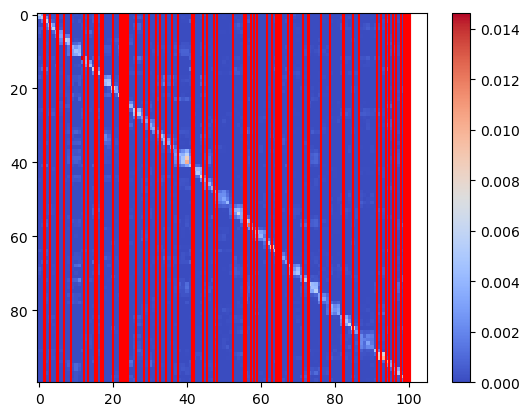

In [19]:
plot_superadj(adj_raw, K=100, sparse=True, labels=labels_raw, dataset=dataset, vline=True)

In [20]:
labels_s = np.sort(np.unique(labels_raw))
nclass = labels_s.shape[0]
node_sizes = []
for cls_id in labels_s:
    node_sizes.append(np.where(labels_raw==cls_id)[0].shape[0])
node_sizes = np.array(node_sizes)

print("Number of Nodes: {}".format(adj_raw.shape[0]))
print("Number of Edges: {}".format(adj_raw.sum()))
print("Dim of features: {}".format(features_raw.shape[-1]))
print("Number of Classes: {}".format(nclass))
print("Number of nodes in each class: {}".format(node_sizes))

Number of Nodes: 19793
Number of Edges: 65311.0
Dim of features: 8710
Number of Classes: 70
Number of nodes in each class: [257  52 243 378  63 305 404 663 240 342 141 223 102 521 341 138 115 111
  80 435 420 254 414 196 334 315 284 783 113 466 221 376 154 855 576  84
 293 163 125 564 280 205  94  53 129 370 122  74 557 285  72 625 501 650
  99 473 324 928 212 301 116 220 165 291 147  91 137  84  15  29]


In [24]:
print(((node_sizes)>=300).sum())

27


In [33]:
def sample_uniform_comms(adj, features, labels, nclass_s=10, num_nodes_per_comm=200, seed=None):
    labels_s = np.sort(np.unique(labels))
    nclass = labels_s.shape[0]
    node_sizes = []
    for cls_id in labels_s:
        node_sizes.append(np.where(labels==cls_id)[0].shape[0])
    node_sizes = np.array(node_sizes)

    large_comms = np.where(node_sizes>=num_nodes_per_comm)[0]
    np.random.RandomState(seed=seed).shuffle(large_comms)
    comms_s = large_comms[:nclass_s]
    n, d = features.shape
    mask = np.zeros(n)
    for i in range(nclass_s):
        comm = comms_s[i]
        node_ids = np.where(labels==comm)[0][:num_nodes_per_comm]
        mask[node_ids] = 1

    mask = np.nonzero(mask)[0]
    
    nodeid_new2old = {k:v for k,v in enumerate(mask)}
    
    adj = adj.toarray()[mask,:][:,mask]
    adj = sp.coo_matrix(adj)
    features = features.toarray()[mask]
    features = sp.coo_matrix(features)
    labels = labels[mask]
    
    old2new = {} #将社区id重新从0开始计数
    cur = 0
    for i, l in enumerate(labels):
        if not l in old2new.keys():
            old2new[l] = cur
            cur += 1
        labels[i] = old2new[l]
            
    
    return adj, features, labels, nodeid_new2old

In [60]:
seed=2
adj, features, labels, nodeid_new2old = sample_uniform_comms(adj_raw, features_raw, labels_raw, nclass_s=25, num_nodes_per_comm=300, seed=seed)

100%|██████████| 100/100 [00:01<00:00, 53.74it/s]


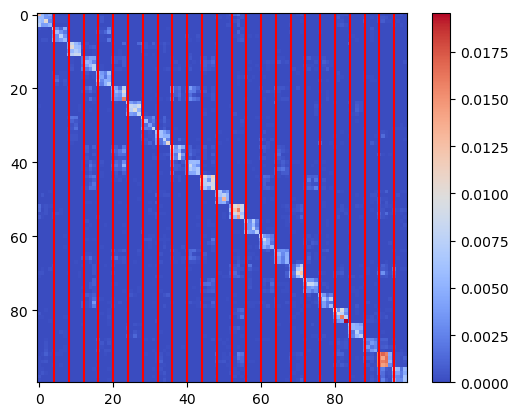

In [61]:
plot_superadj(adj, K=100, sparse=True, labels=labels, dataset=dataset, vline=True)

In [62]:
def sample_diff_classes(adj, features, labels, nodeid_new2old, nclass_s=10, seed=None):
    labels_s = np.sort(np.unique(labels))
    nclass = labels_s.shape[0]
    
    
#     comms_s = np.arange(0, nclass_s, dtype=int)
    comms_s = np.random.RandomState(seed=seed).permutation(nclass)[:nclass_s]
    n, d = features.shape
    mask = np.zeros(n)
    for i in range(nclass_s):
        comm = comms_s[i]
        node_ids = np.where(labels==comm)[0]
        mask[node_ids] = 1

    mask = np.nonzero(mask)[0]
    
    adj = adj.toarray()[mask,:][:,mask]
    adj = sp.coo_matrix(adj)
    features = features.toarray()[mask]
    features = sp.coo_matrix(features)
    labels = labels[mask]
    
    old2new = {}
    cur = 0
    for i, l in enumerate(labels):
        if not l in old2new.keys():
            old2new[l] = cur
            cur += 1
        labels[i] = old2new[l]
    
    mask = [nodeid_new2old[v] for v in mask]
    
    return adj, features, labels, mask

In [63]:
for nclass_s in np.arange(2, 12, 2, dtype=int):
    adj_s, features_s, labels_s, mask_s = sample_diff_classes(adj, features, labels, nodeid_new2old, nclass_s=nclass_s, seed=seed)
    print(nclass_s, adj_s.shape, adj_s.sum())
    
    node_sizes = []
    for cls_id in np.sort(np.unique(labels_s)):
        node_sizes.append(np.where(labels_s==cls_id)[0].shape[0])
    node_sizes = np.array(node_sizes)
    
    print("#"*5, "cora-full-{:d}".format(nclass_s), "#"*5)
    print("Number of Nodes: {}".format(adj_s.shape[0]))
    print("Number of Edges: {}".format(adj_s.sum()))
    print("Dim of features: {}".format(features_s.shape[-1]))
    print("Number of Classes: {}".format(np.unique(labels_s).shape[0]))
    print("Number of nodes in each class: {}".format(node_sizes))
    
    print("Average Size of Communities: {:d}+-{:.2f}".format(int(np.mean(node_sizes)), np.std(node_sizes)))
    print("Imbalanced Rate: {:.2f}".format(np.min(node_sizes)/np.max(node_sizes)))
    
    print()
    
    np.savez("{}_{}_{:d}.npz".format(dataset, nclass_s, seed), data=adj_s.data, row=adj_s.row, col=adj_s.col, features=features_s.toarray(), labels=labels_s, mask=mask_s)

2 (600, 600) 904.0
##### cora-full-2 #####
Number of Nodes: 600
Number of Edges: 904.0
Dim of features: 8710
Number of Classes: 2
Number of nodes in each class: [300 300]
Average Size of Communities: 300+-0.00
Imbalanced Rate: 1.00

4 (1200, 1200) 1938.0
##### cora-full-4 #####
Number of Nodes: 1200
Number of Edges: 1938.0
Dim of features: 8710
Number of Classes: 4
Number of nodes in each class: [300 300 300 300]
Average Size of Communities: 300+-0.00
Imbalanced Rate: 1.00

6 (1800, 1800) 3651.0
##### cora-full-6 #####
Number of Nodes: 1800
Number of Edges: 3651.0
Dim of features: 8710
Number of Classes: 6
Number of nodes in each class: [300 300 300 300 300 300]
Average Size of Communities: 300+-0.00
Imbalanced Rate: 1.00

8 (2400, 2400) 4505.0
##### cora-full-8 #####
Number of Nodes: 2400
Number of Edges: 4505.0
Dim of features: 8710
Number of Classes: 8
Number of nodes in each class: [300 300 300 300 300 300 300 300]
Average Size of Communities: 300+-0.00
Imbalanced Rate: 1.00

10 (3

In [8]:
# 废弃：没有先统一每个社区的大小
def sample_diff_classes(adj, features, labels, nclass_s=10, num_nodes_per_comm=None, seed=None):
    labels_s = np.sort(np.unique(labels))
    nclass = labels_s.shape[0]
    node_sizes = []
    for cls_id in labels_s:
        node_sizes.append(np.where(labels==cls_id)[0].shape[0])
    node_sizes = np.array(node_sizes)
    
    
#     comms_s = np.arange(0, nclass_s, dtype=int)
    comms_s = np.random.RandomState(seed=seed).permutation(nclass)[:nclass_s]
    n, d = features.shape
    mask = np.zeros(n)
    for i in range(nclass_s):
        comm = comms_s[i]
        node_ids = np.where(labels==comm)[0]
        mask[node_ids] = 1

    mask = np.nonzero(mask)[0]
    
    adj = adj.toarray()[mask,:][:,mask]
    adj = sp.coo_matrix(adj)
    features = features.toarray()[mask]
    features = sp.coo_matrix(features)
    labels = labels[mask]
    
    old2new = {}
    cur = 0
    for i, l in enumerate(labels):
        if not l in old2new.keys():
            old2new[l] = cur
            cur += 1
        labels[i] = old2new[l]
            
    
    return adj, features, labels, mask

In [14]:
seed=2
for nclass_s in np.arange(5, 55, 5, dtype=int):
    adj, features, labels, mask = sample_diff_classes(adj_raw, features_raw, labels_raw, nclass_s=nclass_s, seed=seed)
    print(nclass_s, adj.shape, adj.sum())
    np.savez("{}_{}_{:d}.npz".format(dataset, nclass_s, seed), data=adj.data, row=adj.row, col=adj.col, features=features.toarray(), labels=labels, mask=mask)

5 (798, 798) 1216.0
10 (1760, 1760) 3336.0
15 (3131, 3131) 6672.0
20 (4908, 4908) 12468.0
25 (6490, 6490) 17454.0
30 (7353, 7353) 20025.0
35 (8542, 8542) 22644.0
40 (9958, 9958) 26930.0
45 (11997, 11997) 32830.0
50 (13794, 13794) 39948.0


100%|██████████| 100/100 [00:05<00:00, 17.96it/s]


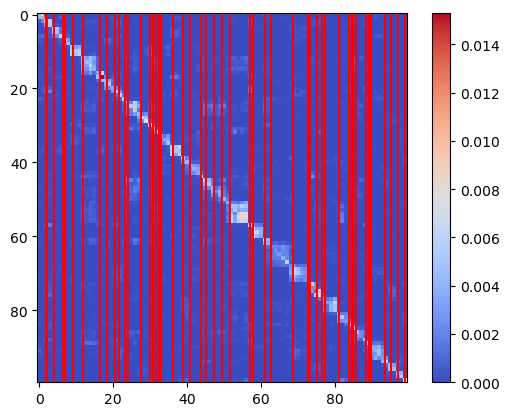

In [17]:
plot_superadj(adj, K=100, sparse=True, labels=labels, dataset=dataset, vline=True)